# **Deep Learning on 3D Meshes**

# Installation
Installing the required packages

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install trimesh

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [6]:
from time import sleep
from pathlib import Path
from itertools import tee
from functools import lru_cache

import trimesh
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.transforms import BaseTransform, Compose, FaceToEdge
from torch_geometric.data import Data, InMemoryDataset, extract_zip, DataLoader

In [4]:
print(torch.version.cuda)

11.7


#Download Annotated MPI FAUST Dataset

In [4]:
!pip install gdown

In [5]:
!gdown --id 1CvfkR6iFOpfo0yRyaVOvgv2piphP6pze

/home/sofialima/miniconda3/envs/dl/lib/python3.10/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CvfkR6iFOpfo0yRyaVOvgv2piphP6pze
To: /home/sofialima/MPI-FAUST.zip
100%|██████████████████████████████████████| 14.6M/14.6M [00:00<00:00, 18.5MB/s]


##Device

You might need to use GPU for this Colab.
Please click Runtime and then Change runtime type. Then set the hardware accelerator to GPU.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def load_mesh(mesh_filename: Path):
    """Extract vertices and faces from raw mesh file.

    Parameters
    ----------
    mesh_filename: PathLike
        Path to mesh `.ply` file.

    Returns
    -------
    vertices: torch.tensor
        Float tensor of size (|V|, 3), where each row
        specifies the spatial position of a vertex in 3D space.
    faces: torch.tensor
        Intger tensor of size (|M|, 3), where each row
        defines a traingular face.
    """
    mesh = trimesh.load_mesh(mesh_filename, process=False)
    vertices = torch.from_numpy(mesh.vertices).to(torch.float)
    faces = torch.from_numpy(mesh.faces)
    faces = faces.t().to(torch.long).contiguous()
    return vertices, faces

# Dataset Defintion

In [9]:
class SegmentationFaust(InMemoryDataset):
    map_seg_label_to_id = dict(
        head=0,
        torso=1,
        left_arm=2,
        left_hand=3,
        right_arm=4,
        right_hand=5,
        left_upper_leg=6,
        left_lower_leg=7,
        left_foot=8,
        right_upper_leg=9,
        right_lower_leg=10,
        right_foot=11,
    )

    def __init__(self, root, train: bool = True, pre_transform=None):
        """
        Parameters
        ----------
        root: PathLike
            Root directory where the dataset should be saved.
        train: bool
            Whether to load training data or test data.
        pre_transform: Optional[Callable]
            A function that takes in a torch_geometric.data.Data object
            and outputs a transformed version. Note that the transformed
            data object will be saved to disk.

        """
        super().__init__(root, pre_transform)
        path = self.processed_paths[0] if train else self.processed_paths[1]
        self.data, self.slices = torch.load(path)

    @property
    def processed_file_names(self) -> list:
        return ["training.pt", "test.pt"]

    @property
    @lru_cache(maxsize=32)
    def _segmentation_labels(self):
        """Extract segmentation labels."""
        path_to_labels = Path(self.root) / "MPI-FAUST"/ "segmentations.npz"
        seg_labels = np.load(str(path_to_labels))["segmentation_labels"]
        return torch.from_numpy(seg_labels).type(torch.int64)

    def _mesh_filenames(self):
        """Extract all mesh filenames."""
        path_to_meshes = Path(self.root)/ "MPI-FAUST" / "meshes"
        return path_to_meshes.glob("*.ply")

    def _unzip_dataset(self):
        """Extract dataset from zip."""
        path_to_zip = Path(self.root) / "MPI-FAUST.zip"
        extract_zip(str(path_to_zip), self.root, log=False)

    def process(self):
        """Process the raw meshes files and their corresponding class labels."""
        self._unzip_dataset()

        data_list = []
        for mesh_filename in sorted(self._mesh_filenames()):
            vertices, faces = load_mesh(mesh_filename)
            data = Data(x=vertices, face=faces)
            data.segmentation_labels = self._segmentation_labels
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        torch.save(self.collate(data_list[:80]), self.processed_paths[0])
        torch.save(self.collate(data_list[80:]), self.processed_paths[1])

In [10]:
class NormalizeUnitSphere(BaseTransform):
    """Center and normalize node-level features to unit length."""

    @staticmethod
    def _re_center(x):
        """Recenter node-level features onto feature centroid."""
        centroid = torch.mean(x, dim=0)
        return x - centroid

    @staticmethod
    def _re_scale_to_unit_length(x):
        """Rescale node-level features to unit-length."""
        max_dist = torch.max(torch.norm(x, dim=1))
        return x / max_dist

    def __call__(self, data: Data):
        if data.x is not None:
            data.x = self._re_scale_to_unit_length(self._re_center(data.x))

        return data

    def __repr__(self):
        return "{}()".format(self.__class__.__name__)

#Network Definitions

We define the mesh segmentation network. It consists of

##Helper Functions
We define helper functions to simplify the creation of graph convolutional layers and multilayered perceptrons. 

In [11]:
def pairwise(iterable):
    """Iterate over all pairs of consecutive items in a list.
    Notes
    -----
        [s0, s1, s2, s3, ...] -> (s0,s1), (s1,s2), (s2, s3), ...
    """
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_conv_layers(channels: list, conv: MessagePassing, conv_params: dict):
    """Define convolution layers with specified in and out channels.

    Parameters
    ----------
    channels: list
        List of integers specifying the size of the convolution channels.
    conv: MessagePassing
        Convolution layer.
    conv_params: dict
        Dictionary specifying convolution parameters.

    Returns
    -------
    list
        List of convolutions with the specified channels.
    """
    conv_layers = [
        conv(in_ch, out_ch, **conv_params) for in_ch, out_ch in pairwise(channels)
    ]
    return conv_layers

In [12]:
def get_mlp_layers(channels: list, activation, output_activation=nn.Identity):
    """Define basic multilayered perceptron network."""
    layers = []
    *intermediate_layer_definitions, final_layer_definition = pairwise(channels)

    for in_ch, out_ch in intermediate_layer_definitions:
        intermediate_layer = nn.Linear(in_ch, out_ch)
        layers += [intermediate_layer, activation()]

    layers += [nn.Linear(*final_layer_definition), output_activation()]
    return nn.Sequential(*layers)

##Feature-Steered Graph Convolution

The foundation for our graph neural network are feature-steered graph convolution ([Verma](https://arxiv.org/pdf/1706.05206.pdf) et al. (2018)). They perform the following layer-wise node-level feature update:

$$ \mathbf{h}_v^{(l)} = \mathbf{b} + \sum_{m=1}^{M}  \frac{1}{|\mathcal{N}_{v}|} \sum_{u \in \mathcal{N}_v} \alpha_m^{(l)}(v, u)\mathbf{W}^{(l)}_{m} \mathbf{h}^{(l-1)}_{u}$$

where $\alpha_m^{(l)}(v, u)$ is the learned attention weight of the $m$-th attention mechanism, $\mathbf{W}_m^{(l)}$ is the associated linear transformation matrix, $\mathcal{N}_v$
is the set of adjacent vertices of vertex $v$ (including $v$ itself), and $|\mathcal{N}_v|$ the set's cardinal. 

The attention coefficients for each layer $l$ are computed as follows:
$$\alpha_m^{(l)}(v, u) = \frac{\exp(\mathbf{u}^{(l) \ T}_m(\mathbf{h}^{(l-1)}_u - \mathbf{h}^{(l-1)}_v) + c_m^{(l)})}{\sum_{m=1}^{M} \exp(\mathbf{u}^{(l) \ T}_m(\mathbf{h}^{(l-1)}_u - \mathbf{h}^{(l-1)}_v) + c_m^{(l)})}, \quad \quad \sum_{m=1}^{M}\alpha_m^{(l)}(i,j) = 1$$

where $\mathbf{u}_m^{(l)}$ and $c_m^{(l)}$ are learnable parameters, specific to each layer $l$. The attention coefficients are normalised so that they sum to $1$.


We implement this graph convolution using [**PyG's MessagePassing**](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) class.

In [13]:
class FeatureSteeredConvolution(MessagePassing):
    """Implementation of feature steered convolutions.

    References
    ----------
    .. [1] Verma, Nitika, Edmond Boyer, and Jakob Verbeek.
       "Feastnet: Feature-steered graph convolutions for 3d shape analysis."
       Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        num_heads: int,
        ensure_trans_invar: bool = True,
        bias: bool = True,
        with_self_loops: bool = True,
    ):
        super().__init__(aggr="mean")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        self.with_self_loops = with_self_loops

        self.linear = torch.nn.Linear(
            in_features=in_channels,
            out_features=out_channels * num_heads,
            bias=False,
        )
        self.u = torch.nn.Linear(
            in_features=in_channels,
            out_features=num_heads,
            bias=False,
        )
        self.c = torch.nn.Parameter(torch.Tensor(num_heads))

        if not ensure_trans_invar:
            self.v = torch.nn.Linear(
                in_features=in_channels,
                out_features=num_heads,
                bias=False,
            )
        else:
            self.register_parameter("v", None)

        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initialization of tuneable network parameters."""
        torch.nn.init.uniform_(self.linear.weight)
        torch.nn.init.uniform_(self.u.weight)
        torch.nn.init.normal_(self.c, mean=0.0, std=0.1)
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0.0, std=0.1)
        if self.v is not None:
            torch.nn.init.uniform_(self.v.weight)

    def forward(self, x, edge_index):
        """Forward pass through a feature steered convolution layer.

        Parameters
        ----------
        x: torch.tensor [|V|, in_features]
            Input feature matrix, where each row describes
            the input feature descriptor of a node in the graph.
        edge_index: torch.tensor [2, E]
            Edge matrix capturing the graph's
            edge structure, where each row describes an edge
            between two nodes in the graph.
        Returns
        -------
        torch.tensor [|V|, out_features]
            Output feature matrix, where each row corresponds
            to the updated feature descriptor of a node in the graph.
        """
        if self.with_self_loops:
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index=edge_index, num_nodes=x.shape[0])

        out = self.propagate(edge_index, x=x)
        return out if self.bias is None else out + self.bias

    def _compute_attention_weights(self, x_i, x_j):
        """Computation of attention weights.

        Parameters
        ----------
        x_i: torch.tensor [|E|, in_feature]
            Matrix of feature embeddings for all central nodes,
            collecting neighboring information to update its embedding.
        x_j: torch.tensor [|E|, in_features]
            Matrix of feature embeddings for all neighboring nodes
            passing their messages to the central node along
            their respective edge.
        Returns
        -------
        torch.tensor [|E|, M]
            Matrix of attention scores, where each row captures
            the attention weights of transformed node in the graph.
        """
        if x_j.shape[-1] != self.in_channels:
            raise ValueError(
                f"Expected input features with {self.in_channels} channels."
                f" Instead received features with {x_j.shape[-1]} channels."
            )
        if self.v is None:
            attention_logits = self.u(x_i - x_j) + self.c
        else:
            attention_logits = self.u(x_i) + self.b(x_j) + self.c
        return F.softmax(attention_logits, dim=1)

    def message(self, x_i, x_j):
        """Message computation for all nodes in the graph.

        Parameters
        ----------
        x_i: torch.tensor [|E|, in_feature]
            Matrix of feature embeddings for all central nodes,
            collecting neighboring information to update its embedding.
        x_j: torch.tensor [|E|, in_features]
            Matrix of feature embeddings for all neighboring nodes
            passing their messages to the central node along
            their respective edge.
        Returns
        -------
        torch.tensor [|E|, out_features]
            Matrix of updated feature embeddings for
            all nodes in the graph.
        """
        attention_weights = self._compute_attention_weights(x_i, x_j)
        x_j = self.linear(x_j).view(-1, self.num_heads, self.out_channels)
        return (attention_weights.view(-1, self.num_heads, 1) * x_j).sum(dim=1)

##Graph Neural Network
We create a graph neural network to derive a node-level feature embedding by stacking featured steered graph convolutions sequentially. 

In [14]:
class GraphFeatureEncoder(torch.nn.Module):
    """Graph neural network consisting of stacked graph convolutions."""
    def __init__(
        self,
        in_features,
        conv_channels,
        num_heads,
        apply_batch_norm: int = True,
        ensure_trans_invar: bool = True,
        bias: bool = True,
        with_self_loops: bool = True,
    ):
        super().__init__()

        conv_params = dict(
            num_heads=num_heads,
            ensure_trans_invar=ensure_trans_invar,
            bias=bias,
            with_self_loops=with_self_loops,
        )
        self.apply_batch_norm = apply_batch_norm

        *first_conv_channels, final_conv_channel = conv_channels
        conv_layers = get_conv_layers(
            channels=[in_features] + conv_channels,
            conv=FeatureSteeredConvolution,
            conv_params=conv_params,
        )
        self.conv_layers = nn.ModuleList(conv_layers)

        self.batch_layers = [None for _ in first_conv_channels]
        if apply_batch_norm:
            self.batch_layers = nn.ModuleList(
                [nn.BatchNorm1d(channel) for channel in first_conv_channels]
            )

    def forward(self, x, edge_index):
        *first_conv_layers, final_conv_layer = self.conv_layers
        for conv_layer, batch_layer in zip(first_conv_layers, self.batch_layers):
            x = conv_layer(x, edge_index)
            x = F.relu(x)
            if batch_layer is not None:
                x = batch_layer(x)
        return final_conv_layer(x, edge_index)

##General Network Definition
The network architecture consists of three components: a MLP encoder network, a graph neural network, a MLP class prediction head.

In [15]:
class MeshSeg(torch.nn.Module):
    """Mesh segmentation network."""
    def __init__(
        self,
        in_features,
        encoder_features,
        conv_channels,
        encoder_channels,
        decoder_channels,
        num_classes,
        num_heads,
        apply_batch_norm=True,
    ):
        super().__init__()
        self.input_encoder = get_mlp_layers(
            channels=[in_features] + encoder_channels,
            activation=nn.ReLU,
        )
        self.gnn = GraphFeatureEncoder(
            in_features=encoder_features,
            conv_channels=conv_channels,
            num_heads=num_heads,
            apply_batch_norm=apply_batch_norm,
        )
        *_, final_conv_channel = conv_channels

        self.final_projection = get_mlp_layers(
            [final_conv_channel] + decoder_channels + [num_classes],
            activation=nn.ReLU,
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.input_encoder(x)
        x = self.gnn(x, edge_index)
        return self.final_projection(x)

#Training Pipeline

We define the training and evaluation pipeline.

In [16]:
def train(net, train_data, optimizer, loss_fn, device):
    """Train network on training dataset."""
    net.train()
    cumulative_loss = 0.0
    for data in train_data:
        data = data.to(device)
        optimizer.zero_grad()
        out = net(data)
        loss = loss_fn(out, data.segmentation_labels.squeeze())
        loss.backward()
        cumulative_loss += loss.item()
        optimizer.step()
    return cumulative_loss / len(train_data)

In [17]:
def accuracy(predictions, gt_seg_labels):
    """Compute accuracy of predicted segmentation labels.

    Parameters
    ----------
    predictions: [|V|, num_classes]
        Soft predictions of segmentation labels.
    gt_seg_labels: [|V|]
        Ground truth segmentations labels.
    Returns
    -------
    float
        Accuracy of predicted segmentation labels.    
    """
    predicted_seg_labels = predictions.argmax(dim=-1, keepdim=True)
    if predicted_seg_labels.shape != gt_seg_labels.shape:
        raise ValueError("Expected Shapes to be equivalent")
    correct_assignments = (predicted_seg_labels == gt_seg_labels).sum()
    num_assignemnts = predicted_seg_labels.shape[0]
    return float(correct_assignments / num_assignemnts)


def evaluate_performance(dataset, net, device):
    """Evaluate network performance on given dataset.

    Parameters
    ----------
    dataset: DataLoader
        Dataset on which the network is evaluated on.
    net: torch.nn.Module
        Trained network.
    device: str
        Device on which the network is located.

    Returns
    -------
    float:
        Mean accuracy of the network's prediction on
        the provided dataset.
    """
    prediction_accuracies = []
    for data in dataset:
        data = data.to(device)
        predictions = net(data)
        prediction_accuracies.append(accuracy(predictions, data.segmentation_labels))
    return sum(prediction_accuracies) / len(prediction_accuracies)

@torch.no_grad()
def test(net, train_data, test_data, device):
    net.eval()
    train_acc = evaluate_performance(train_data, net, device)
    test_acc = evaluate_performance(test_data, net, device)
    return train_acc, test_acc

#Dataset and Preprocessing
Next, we instantiate the mesh segmentation network. Furthermore, we load both the training and test datasets. Note that we normalize all meshes to unit length and convert the mesh's face matrix into an adjacency matrix by applying pre-transformations.

In [18]:
model_params = dict(
    in_features=3,
    encoder_features=16,
    conv_channels=[32, 64, 128, 64],
    encoder_channels=[16],
    decoder_channels=[32],
    num_classes=12,
    num_heads=12,
    apply_batch_norm=True,
)

net = MeshSeg(**model_params).to(device)

In [19]:
!pwd

/home/sofialima


In [20]:
# root = "/content"
root = '/home/sofialima'
pre_transform = Compose([FaceToEdge(remove_faces=False), NormalizeUnitSphere()])

train_data = SegmentationFaust(
    root=root,
    pre_transform=pre_transform,
)
test_data = SegmentationFaust(
    root=root,
    train=False,
    pre_transform=pre_transform,
)
train_loader = DataLoader(train_data,  shuffle=True)
test_loader = DataLoader(test_data, shuffle=False)

/home/sofialima/miniconda3/envs/dl/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#Training Model
Let's train the model on the training dataset.

*Note: The model training pipeline is solely provided for demonstration purposes. It takes a few hundred epochs until the network outputs reasonable node-level class predictions. Thus, we suggest executing the training pipeline from the command line, and using a tensorboard to track the training.*

In [19]:
lr = 0.001
num_epochs = 50
best_test_acc = 0.0

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
with tqdm(range(num_epochs), unit="Epoch") as tepochs:
    for epoch in tepochs:
        train_loss = train(net, train_loader, optimizer, loss_fn, device)
        train_acc, test_acc = test(net, train_loader, test_loader, device)
        
        tepochs.set_postfix(
            train_loss=train_loss,
            train_accuracy=100 * train_acc,
            test_accuracy=100 * test_acc,
        )
        sleep(0.1)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(net.state_dict(), "/home/sofialima/checkpoint_best_colab")

100%|█████████████████████| 50/50 [15:28<00:00, 18.56s/Epoch, test_accuracy=56.5, train_accuracy=57.6, train_loss=0.612]


#Model Evaluation & Prediction Visualization

Now that we have trained the model, let's evaluate its performance on the test-dataset and visualize its predictions of body-part labels.

Note that we also provide a pretrained model, `/content/checkpoint_best_pretrained`. By calling the function `get_best_model` the best model is returned.

In [22]:
!gdown --id 1HxW_JsmFk3CBMvv3Pj3ztSmOOWKxTQtl # download pretrained model

/home/sofialima/miniconda3/envs/dl/lib/python3.10/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HxW_JsmFk3CBMvv3Pj3ztSmOOWKxTQtl 



In [23]:
!ls

Dev				   gltf_buffer_4.bin
MPI-FAUST			   gltf_buffer_5.bin
MPI-FAUST.zip			   gltf_buffer_6.bin
Miniconda3-latest-Linux-x86_64.sh  gltf_buffer_7.bin
__MACOSX			   gltf_buffer_8.bin
aevol				   julia.m
aevol-hpc			   juliatest.m
checkpoint_best_colab		   mesh_seg_final.ipynb
checkpoint_best_pretrained	   mesh_seg_final.ipynb:Zone.Identifier
gltf_buffer_0.bin		   miniconda3
gltf_buffer_1.bin		   processed
gltf_buffer_2.bin		   seg_results.gltf
gltf_buffer_3.bin		   u-net-release-2015-10-02


In [21]:
def load_model(model_params, path_to_checkpoint, device):
    try:
        model = MeshSeg(**model_params)
        model.load_state_dict(
            torch.load(str(path_to_checkpoint)),
            strict=True,
        )
        model.to(device)
        return model
    except RuntimeError as err_msg:
        raise ValueError(
            f"Given checkpoint {str(path_to_checkpoint)} could"
            f" not be loaded. {err_msg}"
        )

def get_best_model(model_params, dataset, device):
    path_to_pretrained_model = Path("/home/sofialima/checkpoint_best_pretrained")
    path_to_trained_model = Path("/home/sofialima/checkpoint_best_colab")

    pretrained_model = load_model(
        model_params,
        path_to_pretrained_model,
        device,
    )
    if not path_to_trained_model.exists():
        return pretrained_model
    
    trained_model = load_model(
        model_params,
        path_to_trained_model,
        device,
    )
    acc_pretrained = evaluate_performance(dataset, pretrained_model, device) 
    acc_trained = evaluate_performance(dataset, trained_model, device)
    if acc_pretrained > acc_trained:
        return pretrained_model
    return trained_model

In [22]:
net = get_best_model(model_params, test_loader, device)

##Define Segmentation Color Map
We define a mapping between the semantic body-part classes and RGB colors. This mapping is used to visualize the prediceted node labels.

In [23]:
segmentation_colors = dict(
    head=torch.tensor([255, 0, 0], dtype=torch.int),
    torso=torch.tensor([255, 0, 255], dtype=torch.int),
    left_arm=torch.tensor([255, 255, 0], dtype=torch.int),
    left_hand=torch.tensor([255, 128, 0], dtype=torch.int), 
    right_arm=torch.tensor([0, 255, 0], dtype=torch.int),
    right_hand=torch.tensor([0, 255, 128], dtype=torch.int),
    left_upper_leg=torch.tensor([0, 128, 255], dtype=torch.int),
    left_lower_leg=torch.tensor([0, 255, 255], dtype=torch.int),
    left_foot=torch.tensor([0, 0, 255], dtype=torch.int),
    right_upper_leg=torch.tensor([128, 0, 255], dtype=torch.int),
    right_lower_leg=torch.tensor([128, 255, 0], dtype=torch.int),
    right_foot=torch.tensor([255, 0, 128], dtype=torch.int)
)
map_seg_id_to_color = dict(
    (_value, segmentation_colors[_key])
    for _key, _value in train_data.map_seg_label_to_id.items()
)

In [24]:
@torch.no_grad()
def visualize_prediction(net, data, device, map_seg_id_to_color):
    """Visualization of predicted segmentation mask.""" 
    def _map_seg_label_to_color(seg_ids, map_seg_id_to_color):
        return torch.vstack(
            [map_seg_id_to_color[int(seg_ids[idx])] for idx in range(seg_ids.shape[0])]
        )

    data = data.to(device)
    predictions = net(data)
    predicted_seg_labels = predictions.argmax(dim=-1, keepdim=True)
    mesh_colors = _map_seg_label_to_color(predicted_seg_labels, map_seg_id_to_color)
    segmented_mesh = trimesh.base.Trimesh(
        vertices=data.x.cpu().numpy(),
        faces=data.face.t().cpu().numpy(),
        process=False,
    )
    segmented_mesh.visual.vertex_colors = mesh_colors.cpu().numpy()
    return segmented_mesh

In [25]:
segmented_meshes = []
mesh_ids = [0, 1, 10, 11]
for idx, mesh_id in enumerate(mesh_ids):
    segmented_mesh = visualize_prediction(net, test_data[mesh_id], device, map_seg_id_to_color)
    segmented_mesh.vertices += [idx * 1.0, 0.0, 0.0]
    segmented_meshes.append(segmented_mesh)

scene = trimesh.scene.Scene(segmented_meshes)
scene.show()

In [36]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 25.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:0000:0100:01


In [27]:
import matplotlib.pyplot as plt

In [48]:
!pip install pyglet==1.5.24

  Using cached pyglet-1.5.24-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.13
    Uninstalling pyglet-1.5.13:
      Successfully uninstalled pyglet-1.5.13


In [26]:
import pyglet

In [44]:
from PIL import Image
import io
# found error in pillow package
# AttributeError: module 'PIL.Image' has no attribute 'fromstring'
# modified source code 'fromstring' to 'frombytes'

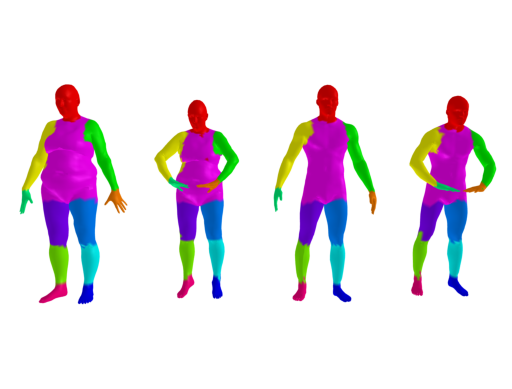

In [46]:
data = scene.save_image()

img = np.array(Image.open(io.BytesIO(data))) 
fig = plt.figure()
plt.imshow(img)
plt.axis('off')
plt.savefig('seg_results_axisoff.png')